In [33]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from CNN_LSTM_MODEL import CNNBiLSTMDepthModel

#### RELOADING DATA

In [34]:
X = torch.load("X_eeg_tf.pt")        # [204, 8, 10, 21]
y = torch.load("y_pseudo.pt")        # [204]
trial_session_ids = torch.load("trial_session_ids.pt")

print(X.shape, y.shape)

torch.Size([207, 8, 10, 21]) torch.Size([207])


### CONFIGURING DATA FOR TRAINING AND TESTING

In [35]:
test_session = 0

train_idx = trial_session_ids != test_session
test_idx  = trial_session_ids == test_session

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("Train samples:", X_train.shape[0])
print("Test samples:",  X_test.shape[0])

Train samples: 72
Test samples: 135


#### INITIALIZING THE MODEL

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

B, C, FREQ, TIME = X.shape

model = CNNBiLSTMDepthModel(num_channels=C)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#### TRAINING ONLY ON TRAINING SESSIONS

In [37]:
train_ds = TensorDataset(X_train.to(device), y_train.to(device))
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits, _, _ = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader):.4f}")

Epoch 10, Train Loss: 0.2439
Epoch 20, Train Loss: 0.2313
Epoch 30, Train Loss: 0.1561
Epoch 40, Train Loss: 0.1523
Epoch 50, Train Loss: 0.0131


#### EVALUATING ON THE UNSEEN SESSION

In [38]:
model.eval()
with torch.no_grad():
    logits_test, _, _ = model(X_test.to(device))
    preds_test = torch.argmax(logits_test, dim=1)
    accuracy_test = (preds_test == y_test.to(device)).float().mean()

print("Test accuracy on session", test_session, ":", accuracy_test.item())

Test accuracy on session 0 : 0.970370352268219


#### CONFUSION MATRIX

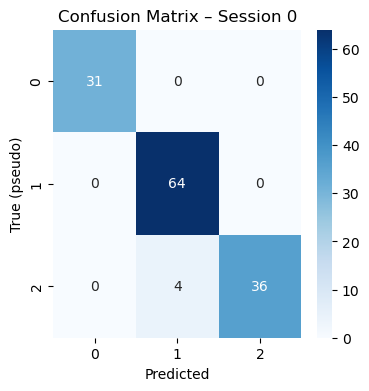

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test.cpu(), preds_test.cpu())

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True (pseudo)")
plt.title(f"Confusion Matrix – Session {test_session}")
plt.show()